In [1]:
# Imports
import sys, os
import pandas as pd
import numpy as np
import matplotlib
import seaborn
import sklearn
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
import chromadb
import joblib


In [2]:
ds = load_dataset("7Xan7der7/us_airline_sentiment")
print(ds)
df = pd.DataFrame(ds["train"])


print("Rows:", len(df))
print("Columns:", list(df.columns))
print("\nSchema:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())
df.head()

DatasetDict({
    train: Dataset({
        features: ['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline', 'name', 'retweet_count', 'text', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone'],
        num_rows: 14640
    })
})
Rows: 14640
Columns: ['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline', 'name', 'retweet_count', 'text', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone']

Schema:
tweet_id                        float64
airline_sentiment                object
airline_sentiment_confidence    float64
negativereason                   object
negativereason_confidence       float64
airline                          object
name                             object
retweet_count                     int64
text                             object
tweet_coord                      object
tweet_created                    o

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,5.703060e+17,neutral,1.0000,None,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,None,2/24/2015 11:35,None,Eastern Time (US & Canada)
1,5.703010e+17,positive,0.3486,None,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,None,2/24/2015 11:15,None,Pacific Time (US & Canada)
2,5.703010e+17,neutral,0.6837,None,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,None,2/24/2015 11:15,Lets Play,Central Time (US & Canada)
3,5.703010e+17,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,None,2/24/2015 11:15,None,Pacific Time (US & Canada)
4,5.703010e+17,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,None,2/24/2015 11:14,None,Pacific Time (US & Canada)


In [3]:
#pd.set_option('display.max_colwidth', None)

print(df[["airline_sentiment", "text"]].head(5))

  airline_sentiment                                               text
0           neutral                @VirginAmerica What @dhepburn said.
1          positive  @VirginAmerica plus you've added commercials t...
2           neutral  @VirginAmerica I didn't today... Must mean I n...
3          negative  @VirginAmerica it's really aggressive to blast...
4          negative  @VirginAmerica and it's a really big bad thing...


Sentiment distribution:
airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

Sentiment confidence stats:
count    14640.000000
mean         0.900169
std          0.162830
min          0.335000
25%          0.692300
50%          1.000000
75%          1.000000
max          1.000000
Name: airline_sentiment_confidence, dtype: float64

Airlines: ['Virgin America' 'United' 'Southwest' 'Delta' 'US Airways' 'American']

Missing 'negativereason': 5462



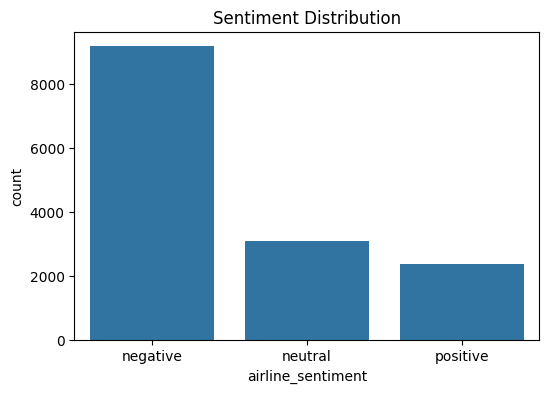

In [4]:
# Cell 4 — EDA: Target distribution & basic stats
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Sentiment class distribution
print("Sentiment distribution:")
print(df["airline_sentiment"].value_counts())
print()

# 2. Confidence stats
print("Sentiment confidence stats:")
print(df["airline_sentiment_confidence"].describe())
print()

# 3. Airlines in dataset
print("Airlines:", df["airline"].unique())
print()

# 4. Missing values in key columns
print("Missing 'negativereason':", df["negativereason"].isna().sum())
print()

# 5. Visualize sentiment distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="airline_sentiment", order=["negative", "neutral", "positive"])
plt.title("Sentiment Distribution")
plt.show()

In [5]:
# Cell 5 — Text length distribution (quick check)
df["text_length"] = df["text"].str.len()

print("Text length stats:")
print(df["text_length"].describe())

# Optional: see if sentiment correlates with length
print("\nAvg length by sentiment:")
print(df.groupby("airline_sentiment")["text_length"].mean())

Text length stats:
count    14640.000000
mean       103.822063
std         36.277339
min         12.000000
25%         77.000000
50%        114.000000
75%        136.000000
max        186.000000
Name: text_length, dtype: float64

Avg length by sentiment:
airline_sentiment
negative    113.947919
neutral      87.359471
positive     86.082945
Name: text_length, dtype: float64


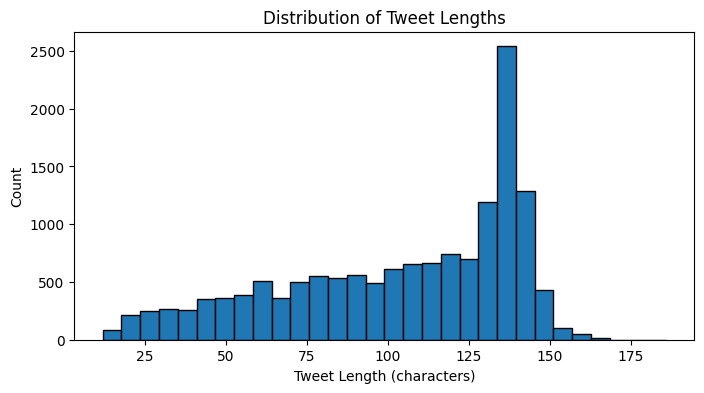

In [6]:
# Add to Cell 5 (after the print statements)
plt.figure(figsize=(8, 4))
plt.hist(df["text_length"], bins=30, edgecolor="black")
plt.xlabel("Tweet Length (characters)")
plt.ylabel("Count")
plt.title("Distribution of Tweet Lengths")
plt.show()

In [7]:
# Cell 7 — Text Preprocessing with Feature Extraction
import re

def clean_text_with_features(text):
    # Extract features BEFORE cleaning
    has_url = 1 if re.search(r"http\S+|www\S+", text) else 0
    mention_count = len(re.findall(r"@\w+", text))
    
    # Replace (not remove) @mentions and URLs with tokens
    text = re.sub(r"@\w+", "<USER>", text)
    text = re.sub(r"http\S+|www\S+", "<URL>", text)
    
    # Lowercase
    text = text.lower()
    # Remove special characters BUT keep < > for tokens
    text = re.sub(r"[^a-z0-9\s<>]", "", text)
    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()
    
    return text, has_url, mention_count

# Apply and create new columns
df[["text_clean", "has_url", "mention_count"]] = df["text"].apply(
    lambda x: pd.Series(clean_text_with_features(x))
)

# Encode labels
label_map = {"negative": 0, "neutral": 1, "positive": 2}
df["label"] = df["airline_sentiment"].map(label_map)

print("Sample with tokens:")
print(df[["text", "text_clean"]].head(3))

Sample with tokens:
                                                text  \
0                @VirginAmerica What @dhepburn said.   
1  @VirginAmerica plus you've added commercials t...   
2  @VirginAmerica I didn't today... Must mean I n...   

                                          text_clean  
0                            <user> what <user> said  
1  <user> plus youve added commercials to the exp...  
2  <user> i didnt today must mean i need to take ...  


In [8]:
# Cell — Analyze tweets with URLs and multiple mentions

# 1. Tweets with URLs: sentiment & confidence
print("=== Tweets WITH URLs ===")
url_tweets = df[df["has_url"] == 1]
print(f"Count: {len(url_tweets)}")
print("Sentiment distribution:")
print(url_tweets["airline_sentiment"].value_counts())
print(f"\nAvg confidence: {url_tweets['airline_sentiment_confidence'].mean():.3f}")
print("\nSample tweets with URL:")
print(url_tweets[["text", "airline_sentiment", "airline_sentiment_confidence"]].head(5))

print("\n" + "="*50 + "\n")

# 2. Tweets with multiple mentions (>1)
print("=== Tweets with MULTIPLE mentions (>1) ===")
multi_mention = df[df["mention_count"] > 1]
print(f"Count: {len(multi_mention)}")
print("Sentiment distribution:")
print(multi_mention["airline_sentiment"].value_counts())
print(f"\nAvg confidence: {multi_mention['airline_sentiment_confidence'].mean():.3f}")
print("\nSample tweets with multiple mentions:")
print(multi_mention[["text", "mention_count", "airline_sentiment"]].head(5))

=== Tweets WITH URLs ===
Count: 1175
Sentiment distribution:
airline_sentiment
neutral     496
negative    448
positive    231
Name: count, dtype: int64

Avg confidence: 0.869

Sample tweets with URL:
                                                 text airline_sentiment  \
7   @VirginAmerica Really missed a prime opportuni...           neutral   
13  @VirginAmerica @virginmedia I'm flying your #f...          positive   
21  @VirginAmerica I love this graphic. http://t.c...          positive   
34  @VirginAmerica this is great news!  America co...          positive   
35  Nice RT @VirginAmerica: Vibe with the moodligh...           neutral   

    airline_sentiment_confidence  
7                         0.6340  
13                        0.6451  
21                        1.0000  
34                        1.0000  
35                        0.6207  


=== Tweets with MULTIPLE mentions (>1) ===
Count: 1578
Sentiment distribution:
airline_sentiment
negative    894
neutral     412
positiv

In [9]:

# Cell 7 — Text Preprocessing for ML
import re

def clean_text(text):
    # Remove @mentions
    text = re.sub(r"@\w+", "", text)
    # Remove URLs
    text = re.sub(r"http\S+|www\S+", "", text)
    # Lowercase
    text = text.lower()
    # Remove special characters (keep letters, numbers, spaces)
    text = re.sub(r"[^a-z0-9\s]", "", text)
    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Apply cleaning
df["text_clean"] = df["text"].apply(clean_text)

# Encode labels
label_map = {"negative": 0, "neutral": 1, "positive": 2}
df["label"] = df["airline_sentiment"].map(label_map)

# Verify
print("Sample cleaned text:")
print(df[["text", "text_clean", "label"]].head(3))
print("\nLabel distribution:")
print(df["label"].value_counts())

Sample cleaned text:
                                                text  \
0                @VirginAmerica What @dhepburn said.   
1  @VirginAmerica plus you've added commercials t...   
2  @VirginAmerica I didn't today... Must mean I n...   

                                          text_clean  label  
0                                          what said      1  
1  plus youve added commercials to the experience...      2  
2  i didnt today must mean i need to take another...      1  

Label distribution:
label
0    9178
1    3099
2    2363
Name: count, dtype: int64


In [10]:
# Cell 8 — Train/Test Split
from sklearn.model_selection import train_test_split

X = df["text_clean"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train size: {len(X_train)}")
print(f"Test size: {len(X_test)}")

Train size: 11712
Test size: 2928


In [11]:
# Cell 9 — TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"TF-IDF shape: {X_train_tfidf.shape}")

TF-IDF shape: (11712, 5000)


In [12]:
# Cell 10 — Train Logistic Regression
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_tfidf, y_train)

print("Training complete!")
print(f"Train accuracy: {model.score(X_train_tfidf, y_train):.4f}")

Training complete!
Train accuracy: 0.8747


In [13]:
# Cell 11 — Evaluate on Test Set
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test_tfidf)

print("Test Accuracy:", model.score(X_test_tfidf, y_test))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["negative", "neutral", "positive"]))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Test Accuracy: 0.7920081967213115

Classification Report:
              precision    recall  f1-score   support

    negative       0.81      0.94      0.87      1835
     neutral       0.67      0.55      0.60       620
    positive       0.84      0.55      0.66       473

    accuracy                           0.79      2928
   macro avg       0.77      0.68      0.71      2928
weighted avg       0.79      0.79      0.78      2928


Confusion Matrix:
[[1720   92   23]
 [ 252  340   28]
 [ 140   74  259]]
